# Library

In [1]:
import numpy as np
import torch
import gpytorch
import argparse
import time
import pickle
import scipy.io as sio

from torch.distributions import Normal
import matplotlib.pyplot as plt
import random

import roslib
import rospy
import tf as tf_ros
from nav_msgs.msg import Odometry, Path
from sensor_msgs.msg import Image
from cv_bridge import CvBridge
from geometry_msgs.msg import PoseStamped, PoseArray, Pose
import math
import cv2
import copy

import sys
sys.path.append('..')

the rosdep view is empty: call 'sudo rosdep init' and 'rosdep update'


## Check GPU

In [2]:
import torch
import numpy as np
import sys
sys.path.append('..')

from torchlib.utils import list_device,set_device

# S1: check GPU
#list_device()

# S2: default parameters
set_device(1)
np.set_printoptions(precision = 2)
torch.set_default_dtype(torch.float32)
torch.set_printoptions(precision=4)
torch.backends.cudnn.benchmark = True
torch.set_printoptions(sci_mode=False)

Using Device 1 : TITAN Xp


# Set Arguments

In [3]:
import argparse
import sys
import os
import time
import pickle

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type=int, default=300, help='size of mini batch')
parser.add_argument('--is_normalization', type=bool, default=True, help='whether do data normalization')
parser.add_argument('--target_image_size', default=[300, 300], nargs=2, type=int, help='Input images will be resized to this for data argumentation.')
parser.add_argument('--output_dim', default=3, type=int, help='output dimention.')
parser.add_argument('--feat_dim', default=128, type=int, help='feature dimention.')
parser.add_argument('--model_dir', type=str, default='/notebooks/global_localization/class_gps_torch', help='rnn, gru, or lstm')

parser.add_argument('--test_dataset', type=str, default=[# '/notebooks/michigan_nn_data/2012_01_08',
                                                         # '/notebooks/michigan_nn_data/2012_01_15',
                                                         # '/notebooks/michigan_nn_data/2012_01_22',
                                                         # '/notebooks/michigan_nn_data/2012_02_02',
                                                         # '/notebooks/michigan_nn_data/2012_02_04',
                                                         # '/notebooks/michigan_nn_data/2012_02_05',
                                                         '/notebooks/michigan_nn_data/2012_02_12',
                                                         # '/notebooks/michigan_nn_data/2012_03_31',
                                                         '/notebooks/michigan_nn_data/2012_04_29',
                                                         '/notebooks/michigan_nn_data/2012_05_11',
                                                         '/notebooks/michigan_nn_data/2012_06_15',
                                                         '/notebooks/michigan_nn_data/2012_08_04',
                                                         # '/notebooks/michigan_nn_data/2012_09_28'])
                                                         '/notebooks/michigan_nn_data/2012_10_28',
                                                         '/notebooks/michigan_nn_data/2012_11_16',
                                                         '/notebooks/michigan_nn_data/2012_12_01'
                                                        ] )

parser.add_argument('--train_dataset', type=str, default = ['/notebooks/michigan_nn_data/test'])
parser.add_argument('--norm_tensor', type=str, default = ['/notebooks/global_localization/norm_mean_std.pt'])

#parser.add_argument('--map_dataset', type=str, default='/home/kevin/data/michigan_gt/training')
parser.add_argument('--seed', default=1337, type=int)
parser.add_argument('--enable_ros', type=bool, default=False, help='put data into ros')

sys.argv = ['']
args = parser.parse_args()

if args.enable_ros:
    rospy.init_node('global_localization_tf_broadcaster_cnn')

# Load Dataset

In [4]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import tf.transformations as tf_tran
from tqdm import tqdm
#from PIL import Image
import numpy as np
import random

#
import gpytorch

import torch.nn as nn
import torch.optim as optim
from torchlib import resnet, vggnet, cnn_auxiliary
from torchlib.cnn_auxiliary import normalize, denormalize, denormalize_navie, get_relative_pose, translational_rotational_loss
from torchlib.utils import LocalizationDataset, display_loss, data2tensorboard
import time

transform = transforms.Compose([transforms.ToTensor()])
dataset = LocalizationDataset(dataset_dirs = args.test_dataset, \
                              image_size = args.target_image_size, \
                              transform = transform, get_pair = False, mode='evaluate')

if len(args.train_dataset)>7:
    [args.norm_mean, args.norm_std] = [torch.tensor(x) for x in dataset.get_norm()]
    torch.save([args.norm_mean, args.norm_std], *args.norm_tensor)
    print('Save norm and std:',*args.norm_tensor)
else:
    [args.norm_mean, args.norm_std] = torch.load(*args.norm_tensor)
    print('Load norm and std:',*args.norm_tensor)

    
dataloader = DataLoader(dataset, batch_size=args.batch_size, \
                        shuffle=False, num_workers=0, \
                        drop_last=False, pin_memory=True)

100%|██████████| 12683/12683 [00:16<00:00, 766.68it/s]


Load norm and std: /notebooks/global_localization/norm_mean_std.pt


# Grid

Grid_num: 32


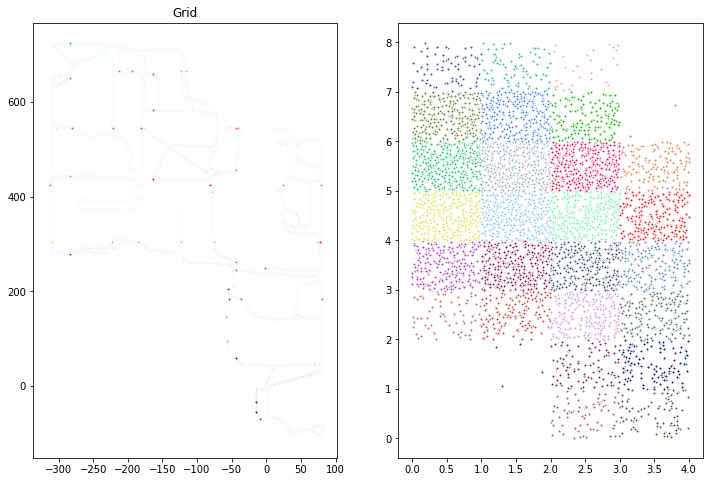

[0, 19, 3930, 4558, 0, 211, 5207, 6231, 3552, 8411, 12759, 9407, 13203, 18475, 16007, 9852, 21476, 25737, 20575, 12052, 22154, 28820, 20675, 8161, 14323, 17898, 7602, 125, 3994, 4559, 1454, 0]


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import pickle

class Grid:
    def __init__(self,grid_size=100.,overlap=50.,**kwargs):
        self.grid_size = grid_size
        self.overlap = overlap
        if 'data' in kwargs:
            data = kwargs['data']
            assert data.shape[1] == 2
            self.boundary_x = [np.min(data[:,0]), np.max(data[:,0])]
            self.boundary_y = [np.min(data[:,1]), np.max(data[:,1])]
            self.boundary_offset = [self.boundary_x[0],self.boundary_y[0]]
            self.num_grid_x,self.num_grid_y = self._cal_grid_num()
            self.num_grid = self.num_grid_x * self.num_grid_y
            self.weight = np.array([1, self.num_grid_x])
            self.weight_matrix = np.array([[1,self.num_grid_x,0,0],
                                           [1,0,0,self.num_grid_x],
                                           [0,self.num_grid_x,1,0],
                                           [0,0,1,self.num_grid_x]]).T
            self.grid_range_x,self.grid_range_y = self._cal_grid_range()
            self.save(os.path.join(args.model_dir,'grid.pkl'))
            print('Save Grids to',os.path.join(args.model_dir,'grid.pkl'))
        
    def _lenght(self):
        x_len = self.boundary_x[1] - self.boundary_x[0]
        y_len = self.boundary_y[1] - self.boundary_y[0]
        return x_len,y_len
    
    def _cal_grid_num(self):
        x_len,y_len = self._lenght()
        num_x_grid = math.ceil(x_len/self.grid_size)
        num_y_grid = math.ceil(y_len/self.grid_size)
        return num_x_grid,num_y_grid
    
    def _cal_grid_range(self):
        grid_range_x = list()
        grid_range_y = list()
        for x_inde in range(self.num_grid_x):
            x = x_inde*self.grid_size + self.boundary_x[0]
            grid_range_x.append([x-self.overlap,x+self.overlap+self.grid_size])

        for y_inde in range(self.num_grid_y):
            y = y_inde*self.grid_size + self.boundary_y[0]
            grid_range_y.append([y-self.overlap,y+self.overlap+self.grid_size])
        return np.array(grid_range_x),np.array(grid_range_y)
    
    def _grid_index(self,x,y):
        x_s = np.searchsorted(self.grid_range_x[:,1],x)
        x_s = min(max(x_s,0),self.num_grid_x-1)
        x_index = [x_s,x_s+1] if x_s+1 < self.num_grid_x and self.grid_range_x[x_s+1,0] < x else [x_s,x_s]
        
        y_s = np.searchsorted(self.grid_range_y[:,1],y)
        y_s = min(max(y_s,0),self.num_grid_y-1)
        y_index = [y_s,y_s+1] if y_s+1 < self.num_grid_y and self.grid_range_y[y_s+1,0] < y else [y_s,y_s]
        
        return x_index,y_index
    
    def in_grids(self,x,y):
        x_index,y_index = self._grid_index(x,y)
        #print(x_index,y_index)
        box = []
        for x_i in x_index:
            for y_i in y_index:
                box += [x_i+y_i*self.num_grid_x]
        return box
    
    def in_grids_exact_v(self,X):
        X = np.floor_divide(X - self.boundary_offset, self.grid_size)
        X = X @ self.weight
        return X
    
    def in_grids_v(self,X):
        X = X - self.boundary_offset
        X_l = np.floor_divide(X - self.overlap, self.grid_size)
        X_l[X_l<0] = 0
        X_h = np.floor_divide(X + self.overlap, self.grid_size)
        X_h[:,0][X_h[:,0]>=self.num_grid_x] = self.num_grid_x -1
        X_h[:,1][X_h[:,1]>=self.num_grid_y] = self.num_grid_y -1
        out = np.hstack([X_l,X_h]) @ self.weight_matrix
        return out

    def save(self,filename = 'grid.pkl'):
        with open(filename,'wb') as f:
            f.write(pickle.dumps(self))

    def load(self,filename = 'grid.pkl'):
        with open(filename,'rb') as f:
            dataPickle = f.read()
            self = pickle.loads(dataPickle)

def draw(X,grid,seed=args.seed):
    label_mask = grid.in_grids_v(X)
    '''
    label_mask = np.zeros([X.shape[0],4])
    for i in range(X.shape[0]):
        label_mask[i] = np.array(grid.in_grids(*X[i]))
    '''

    np.random.seed(seed)
    r = lambda: np.random.randint(0,255)
    colors = ['#%02X%02X%02X' % (r(),r(),r()) for _ in range(grid.num_grid)]
    fig = plt.figure(figsize=(12, 8))
    
    ax = fig.add_subplot(1, 2, 1)
    for k, col in zip(range(grid.num_grid), colors):
        my_members = np.sum(label_mask == k,axis=1) >= 1
        ax.plot(X[my_members, 0], X[my_members, 1], 'w',
                markerfacecolor=col, marker='.')
    ax.set_title('Grid')
    #plt.show()
    
    dis = []
    for i in range(grid.num_grid):
        dis += [np.sum(np.sum(label_mask == i,axis=1)>=1)]
    
    ax = fig.add_subplot(1, 2, 2)
    for i,dense in enumerate(dis):
        row,line = divmod(i,grid.num_grid_x)
        x = np.random.rand(dense//50) + line
        y = np.random.rand(dense//50) + row
        ax.plot(x, y, 'w',markerfacecolor=colors[i], marker='.')
    plt.show()
    return dis
      
grid = Grid()
filename = os.path.join(args.model_dir,'grid.pkl')
with open(filename,'rb') as f:
    dataPickle = f.read()
    grid = pickle.loads(dataPickle)
print('Grid_num:',grid.num_grid)

dis = draw(np.array(dataset.Targets)[:,:2],grid)
print(dis)

# Define Model

In [6]:
from torchlib.model import Backbone, NN, GP#, GPNode_local
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.likelihoods import BernoulliLikelihood

class BasicTrainer:
    def __init__(self,norm_mean,norm_std):
        self.model = None
        self.norm_mean = args.norm_mean.cuda()
        self.norm_std = args.norm_std.cuda()
        
    def disable_requires_grad(self,model):
        for param in model.parameters():
            param.requires_grad = False
            
    def load_model(self, file_name = 'pretrained.pth'):
        # load file info
        state_dict = torch.load(os.path.join(args.model_dir, file_name))
        if 'net.resnet.conv1.weight' in state_dict:
            print('Transform from old model.')
            # Part 1: backbone
            backbone_state_dict = self._from_old_model(state_dict,'backbone')
            print('Backbone parameters layer:',len(backbone_state_dict.keys()))
            self.model.backbone.load_state_dict(backbone_state_dict,strict = True)
            # Part 2: nn
            nn_state_dict = self._from_old_model(torch.load(os.path.join(args.model_dir, file_name)),'nn')
            print('NN parameters layer:',len(nn_state_dict.keys()))
            self.model.nn.load_state_dict(nn_state_dict,strict = True)
        else:
            print('Parameters layer:',len(state_dict.keys()))
            # load file to model
            self.model.load_state_dict(state_dict,strict = True)
        # Display model structure
        #print('Model Structure:')
        #for name, param in self.model.named_parameters():
        #    print(name, param.shape)
        print('Successfully loaded model...')
        print('Parameters layer:',len(self.model.state_dict().keys()))
    
    def _from_old_model(self, state_dict, select = 'backbone'):
        if select == 'backbone':
            for key in list(state_dict):
                if 'net.resnet.' in key:
                    state_dict[key.replace('net.resnet.','resnet.')] = state_dict.pop(key)
                else:
                    state_dict.pop(key)
        elif select == 'nn':
            for key in list(state_dict):
                if 'net.global_regressor.' in key:
                    state_dict[key.replace('net.global_regressor.','global_regressor.')] = state_dict.pop(key)
                elif 'net.global_context.' in key:
                    state_dict[key.replace('net.global_context.','global_context.')] = state_dict.pop(key)
                else:
                    state_dict.pop(key)
        return state_dict
    
    def save_model(self, file_name = 'model-{}-{}.pth'):
        checkpoint_path = os.path.join(args.model_dir, file_name)
        torch.save(self.model.state_dict(),checkpoint_path)
        print('Saving model to ' +  file_name)
        
    def show_require_grad(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                print (name, param.shape)

class GPNode_local(nn.Module):
    def __init__(self,inducing_points):
        super(GPNode_local,self).__init__()
        output_dim = inducing_points.shape[0] # 3-dim
        feat_dim = inducing_points.shape[-1]
        
        self.gp = GP(inducing_points)
        self.likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=output_dim) 
        
    def forward(self,input_data):
        output = self.gp(input_data)
        return output

class GPNode_global(nn.Module):
    def __init__(self,inducing_points,num_gp):
        super(GPNode_global,self).__init__()
        output_dim = inducing_points.shape[0] # num_gp
        feat_dim = inducing_points.shape[-1]
        
        self.gp = GP(inducing_points,num_gp)
        self.likelihood = gpytorch.likelihoods.SoftmaxLikelihood(num_features=num_gp, num_classes=num_gp)
        
    def forward(self,input_data):
        output = self.gp(input_data)
        return output

class Model(nn.Module):
    def __init__(self,num_grid):
        super().__init__()
        self.num_gp = num_grid
        # Part 1: basic NN
        self.backbone = Backbone()
        self.nn = NN()
        # Part 2: global GP
        inducing_points = torch.zeros(self.num_gp, args.batch_size, args.feat_dim)
        #inducing_points = torch.zeros(self.num_gp, 100, args.feat_dim)
        self.global_gp = GPNode_global(inducing_points,self.num_gp)
        # Part 3: local GPs
        self.local_gps = nn.ModuleList()
        for i in range(self.num_gp):
            inducing_points = torch.zeros(args.output_dim, args.batch_size, args.feat_dim)
            #inducing_points = torch.zeros(args.output_dim, 500, args.feat_dim)
            gp = GPNode_local(inducing_points)
            self.local_gps.append(gp)
        
    def forward_nn(self, input_data):
        dense_feat = self.backbone(input_data)
        output, feature_t, feature_r = self.nn(dense_feat)
        rot_pred = torch.split(output, [3, 4], dim=1)[1] # 4-dimention            
        return feature_t, rot_pred
    
    def forward_gp(self,gp,trans_feat):
        trans_pred = gp(trans_feat)
        return trans_pred

In [7]:
class Trainer(BasicTrainer):
    def __init__(self, grid, norm_mean, norm_std,
                 regressor_context_rate = [0.0,0.0],
                 is_training=True, disable_rot_learning = True, 
                 train_global_gp = True, train_local_gps = True):
        
        super().__init__(norm_mean, norm_std)
        self.model = Model(grid.num_grid).cuda()
        self.disable_rot_learning = disable_rot_learning
        self.train_global_gp = train_global_gp
        self.train_local_gps = train_local_gps
        
        self.disable_requires_grad(self.model.backbone)
        
        if is_training:
            # training tool
            self.optimizer = optim.Adam(self._optimize(regressor_context_rate))
            self.scheduler = optim.lr_scheduler.LambdaLR(optimizer=self.optimizer,
                                                             lr_lambda=lambda epoch: args.decay_rate**epoch)
        else:
            self.disable_requires_grad(self.model)
            
    def _optimize(self,regressor_context_rate):
        optimizer = list()
        # Local GPs
        if self.train_local_gps:
            optimizer += [
                    {'params': self.model.local_gps.parameters(), \
                     'lr': args.learning_rate,'weight_decay':args.weight_decay}]
        else:
            self.disable_requires_grad(self.model.local_gps)
            
        # Global GP
        if self.train_global_gp:
            optimizer += [{'params': self.model.global_gp.parameters(), \
                 'lr': args.learning_rate,'weight_decay':args.weight_decay}]
        else:
            self.disable_requires_grad(self.model.global_gp)
            
        # NN
        if regressor_context_rate[0]!=0:
            optimizer += [{'params': self.model.nn.global_regressor.parameters(), \
                 'lr': args.learning_rate * regressor_context_rate[0],'weight_decay':args.weight_decay}]
            print('Regressor learn rate:',regressor_context_rate[0])
        else:
            self.disable_requires_grad(self.model.nn.global_regressor)
                
        if regressor_context_rate[1]!=0:
            optimizer += [{'params': self.model.nn.global_context.parameters(), \
                 'lr': args.learning_rate * regressor_context_rate[1],'weight_decay':args.weight_decay}]
            print('Context learn rate:',regressor_context_rate[1])
        else:
            self.disable_requires_grad(self.model.nn.global_context)
            
        if self.disable_rot_learning and regressor_context_rate[1]!=0.0:
            print("Warning: Set 'disable_rot_learning' to False")
            self.disable_rot_learning = False
        
        if self.disable_rot_learning and regressor_context_rate[1]==0.0:
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.fc1_rot)
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.fc2_rot)
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.fc3_rot)
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.logits_r)
                
        return optimizer
    
    def train(self,x,y):
        # Step 0: zero grad
        self.optimizer.zero_grad()
        start = time.time()
        
        if self.train_local_gps:
            label = grid.in_grids_v(y[:,:2].numpy()) # n x 4
        if self.train_global_gp:
            label_exact = grid.in_grids_exact_v(y[:,:2].numpy()) # n x ,
            label_exact = torch.from_numpy(label_exact).cuda() # n x ,
        x,y = x.cuda(),y.cuda()
        
        if args.is_normalization:
            y = normalize(y,self.norm_mean, self.norm_std) # input should be 7 dim
            
        # Step 2: training
        assert self.model.training == True
        
        trans_loss = torch.tensor(0.).cuda()
        global_gp_loss = torch.tensor(0.).cuda()
        local_gps_loss = np.zeros(self.model.num_gp)
        
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        trans_feat, rot_pred = self.model.forward_nn(x)
        
        if not self.disable_rot_learning:
            rot_loss = self._nn_loss(rot_pred,rot_target)
        
        # Step 2-1: global GP classification
        if self.train_global_gp:
            num_data = min(len(dataloader)*args.batch_size,len(dataset))
            global_gp_loss = self._gp_loss(self.model.global_gp,num_data,trans_feat,label_exact)
        
        # Step 2-2: local GPs regression
        if self.train_local_gps:
            num_batch_data = 0
            for i,gp in enumerate(self.model.local_gps):
                num_data = dis[i]
                if num_data > 0:
                    label_mask = np.sum(label == i,axis=1) >= 1
                    sub_x = trans_feat[label_mask]
                    sub_y = trans_target[label_mask] # unnormalized data 
                    if sub_y.shape[0]>0:
                        gp_loss = self._gp_loss(gp,num_data,sub_x,sub_y)
                        local_gps_loss[i] = float(gp_loss)
                        trans_loss += gp_loss * int(sub_y.shape[0])
                        num_batch_data += int(sub_y.shape[0])
            trans_loss = trans_loss/num_batch_data
        
        # Step 2-3: rotation 
        if not self.disable_rot_learning:
            if self.train_global_gp:
                total_loss = trans_loss + global_gp_loss + args.lamda_weights * rot_loss
            else:
                total_loss = trans_loss + args.lamda_weights * rot_loss
        else:
            if self.train_global_gp:
                total_loss = trans_loss + global_gp_loss
            else:
                total_loss = trans_loss
            
        #Step 3: update
        if self.train_global_gp or self.train_local_gps:
            total_loss.backward()
            self.optimizer.step()
        
        batch_time = time.time() - start
        return float(total_loss), float(global_gp_loss), local_gps_loss, batch_time
        
    def _nn_loss(self,rot_pred,rot_target):
        rot_loss = 1. - torch.mean(torch.square(torch.sum(torch.mul(rot_pred,rot_target),dim=1)))
        return rot_loss
        
    def _gp_loss(self,gp,num_data,trans_feat,trans_target):
        trans_pred = self.model.forward_gp(gp, trans_feat)
        #mll = gpytorch.mlls.VariationalELBO(gp.likelihood, gp.gp, 
        #                                    num_data=num_data).cuda()
        mll = gpytorch.mlls.PredictiveLogLikelihood(gp.likelihood, gp.gp, 
                                            num_data=num_data).cuda()
        
        trans_loss = -1.*mll(trans_pred, trans_target)
        return trans_loss
    
    def _eval_gp(self, gp, trans_pred):
        c_mean, c_var = trans_pred.mean, trans_pred.variance
        y_mean, y_var = gp.likelihood(trans_pred).mean, gp.likelihood(trans_pred).variance
        
        return y_mean, c_mean, c_var
    
    def _sample(self, mean, var, num_sample = 100):
        dist = Normal(mean, var)
        samples = dist.sample([num_sample])
        return samples
    
    def eval_classifier(self,x,y):
        label_exact = grid.in_grids_exact_v(y[:,:2].numpy()) # n x ,
        label_exact = torch.from_numpy(label_exact).cuda() # n x ,
        x = x.cuda()
        
        assert self.model.training == False
    
        trans_feat, rot_pred = self.model.forward_nn(x)
        with torch.no_grad(), gpytorch.settings.num_likelihood_samples(100):
            output = self.model.forward_gp(self.model.global_gp,trans_feat)
            output = self.model.global_gp.likelihood(output)
            pred = output.probs.mean(0).argmax(-1)
        return pred, label_exact        
    
    def eval_forward(self,x,y,num_sample = 100, output_denormalize = True, label_from_gp = True):
        # Step 1: get data
        x,y = x.cuda(),y.cuda()
        
        if not label_from_gp:
            label = grid.in_grids_exact_v(y[:,:2].cpu().numpy()) # n x 4
        else:
            label,_ = self.eval_classifier(x.cpu(),y.cpu())
        
        # Step 2: forward
        assert self.model.training == False
        trans_feat, rot_pred = self.model.forward_nn(x)
        
        trans_pred = torch.zeros(y.shape[0],args.output_dim).cuda()
        trans_mean = torch.zeros(y.shape[0],args.output_dim).cuda()
        trans_var = torch.zeros(y.shape[0],args.output_dim).cuda()
        
        for i,gp in enumerate(self.model.local_gps):
            label_mask = label == i
            sub_x = trans_feat[label_mask]
            if sub_x.shape[0]>0:
                sub_trans_pred = self.model.forward_gp(gp,sub_x)
                sub_trans_pred, sub_trans_mean, sub_trans_var = self._eval_gp(gp, sub_trans_pred)
                if args.is_normalization and output_denormalize:
                    trans_pred[label_mask] = denormalize_navie(sub_trans_pred,self.norm_mean,self.norm_std)
                    trans_mean[label_mask] = denormalize_navie(sub_trans_mean,self.norm_mean,self.norm_std)
                    trans_var[label_mask] = sub_trans_var.mul(self.norm_std)
                else:
                    trans_pred[label_mask] = sub_trans_pred
                    trans_mean[label_mask] = sub_trans_mean
                    trans_var[label_mask] = sub_trans_var
                    
        samples = self._sample(trans_mean, trans_var, num_sample)
        
        # Step 3: split output
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        
        return trans_pred, rot_pred, trans_target, rot_target, samples

trainer = Trainer(grid,args.norm_mean,args.norm_std,is_training=False)

#trainer.load_model('pretrained.pth')
trainer.load_model('model-5-2500.pth')
trainer.show_require_grad()

Parameters layer: 675
Successfully loaded model...
Parameters layer: 675


# Initialize

In [8]:
trans_errors = []
rot_errors = []
uncertainties = []
pose_map = []

total_trans_error = 0.
total_rot_error = 0.

count = 0.

is_save_map = False
is_read_map = False

trans_preds = []
trans_gts = []

rot_preds = []
rot_gts = []

pred_uncertainties = []

pred_time = []

br = tf_ros.TransformBroadcaster()

GT_POSE_TOPIC = '/gt_pose'
BIRDVIEW_TOPIC_PUB = '/bird_view'
MAP_TOPIC_PUB = '/pose_map'
PARTICLES_PUB = '/particles'
NN_LOCALIZASION_PUB = '/nn_pose'
gt_pose_pub = rospy.Publisher(GT_POSE_TOPIC, Odometry, queue_size=1)
bird_view_pub = rospy.Publisher(BIRDVIEW_TOPIC_PUB, Image, queue_size=1)
map_pub = rospy.Publisher(MAP_TOPIC_PUB, Path, queue_size=1)
particles_pub = rospy.Publisher(PARTICLES_PUB, PoseArray, queue_size=1)
nn_pose_pub = rospy.Publisher(NN_LOCALIZASION_PUB, Odometry, queue_size=1)

In [9]:
trainer.model.eval()

accs = 0
for b, data in enumerate(dataloader, 0):
    x,y = data.values()
    pred, target = trainer.eval_classifier(x,y)
    acc = float(torch.sum(pred - target == 0))/float(target.shape[0])
    accs += acc
    if b % 10 == 0:
        print(acc)
print('ACC:', accs/(b+1))

0.9766666666666667
0.9933333333333333
0.99
1.0
1.0
0.9833333333333333
0.9633333333333334
1.0
0.9933333333333333
1.0
1.0
0.9266666666666666
0.9633333333333334
0.98
0.9666666666666667
0.9566666666666667
0.9966666666666667
0.9866666666666667
0.9533333333333334
0.9966666666666667
0.98
0.9333333333333333
0.95
0.99
0.9466666666666667
0.6433333333333333
0.81
0.9666666666666667
0.83
0.92
0.9833333333333333
ACC: 0.9446688382193271


In [10]:
trainer.model.eval()

for b, data in enumerate(dataloader, 0):
    start = time.time()
    x,y = data.values()
    trans_pred, rot_pred, trans_gt, rot_gt, samples = trainer.eval_forward(x,y,label_from_gp = True)
    
    # transform data
    trans_pred = trans_pred.cpu().numpy()
    rot_pred = rot_pred.cpu().numpy()
    trans_gt = trans_gt.cpu().numpy()
    rot_gt = rot_gt.cpu().numpy()
    
    end = time.time()
    
    if args.enable_ros:
        particles = PoseArray()
        particles.header.stamp = rospy.Time.now()
        particles.header.frame_id = 'world'
        for s in samples:
            pose = Pose()
            [pose.position.x, pose.position.y, pose.position.z] = s
            [pose.orientation.x, pose.orientation.y, pose.orientation.z, pose.orientation.w] = rot_pred[0]
            particles.poses.append(pose)
        particles_pub.publish(particles)

        [px_pred, py_pred, pz_pred] = trans_pred[0]
        [qx_pred, qy_pred, qz_pred, qw_pred] = rot_pred[0]

        br.sendTransform((px_pred, py_pred, pz_pred),
                         (qx_pred, qy_pred, qz_pred, qw_pred), rospy.Time.now(),
                         "estimation", "world")

        [px_gt, py_gt, pz_gt] = trans_gt[0]
        [qx_gt, qy_gt, qz_gt, qw_gt] = rot_gt[0]

        br.sendTransform((px_gt, py_gt, pz_gt),
                         (qx_gt, qy_gt, qz_gt, qw_gt),
                         rospy.Time.now(), "gt", "world")

        timestamp = rospy.Time.now()

        nn_pose_msg = Odometry()
        nn_pose_msg.header.frame_id = 'world'
        nn_pose_msg.header.stamp = timestamp
        nn_pose_msg.child_frame_id = 'base_link'
        nn_pose_msg.pose.pose.position.x = px_pred
        nn_pose_msg.pose.pose.position.y = py_pred
        nn_pose_msg.pose.pose.position.z = pz_pred
        [nn_pose_msg.pose.pose.orientation.x, nn_pose_msg.pose.pose.orientation.y, nn_pose_msg.pose.pose.orientation.z, nn_pose_msg.pose.pose.orientation.w] = [qx_pred, qy_pred, qz_pred, qw_pred]

        conv = np.zeros((6,6), dtype=np.float32)
        [conv[0][0], conv[1][1], conv[2][2]] = trans_cov[0]
        nn_pose_msg.pose.covariance = conv.flatten().tolist()
        nn_pose_pub.publish(nn_pose_msg)

        bridge = CvBridge()

        bird_view_img_msg = bridge.cv2_to_imgmsg(np.asarray(x[0].cpu(), dtype=np.float32), encoding="passthrough")
        stamp_now = rospy.Time.now()
        bird_view_img_msg.header.stamp = stamp_now

        bird_view_pub.publish(bird_view_img_msg)

        rospy.sleep(.0)
        cv2.waitKey(0)

        count += 1
    else:
        count += y.shape[0]
    
    trans_preds += [x for x in trans_pred]
    rot_preds += [x for x in rot_pred]
    trans_gts += [x for x in trans_gt]
    rot_gts += [x for x in rot_gt]

    trans_error = np.sqrt(np.sum((trans_pred - trans_gt)**2,axis=1))
    rot_error_1 = np.arccos(np.sum(np.multiply(rot_pred,rot_gt),axis=1))/math.pi*180
    rot_error_2 = np.arccos(np.sum(np.multiply(rot_pred,-rot_gt),axis=1))/math.pi*180
    rot_error = np.minimum(rot_error_1,rot_error_2)

    trans_errors += [x for x in trans_error]
    rot_errors += [x for x in rot_error]

    total_trans_error += np.sum(trans_error)
    total_rot_error += np.sum(rot_error)
    
    display = 1

    if b % display == 0:
        print(
            "{}/{}, translation error = {:.3f}, rotation error = {:.3f}, time/batch = {:.3f}"
            .format(
             (b+1)*args.batch_size,
            len(dataloader)*args.batch_size,
            total_trans_error / count,
            total_rot_error / count,
            end - start))

300/92100, translation error = 2.326, rotation error = 2.759, time/batch = 1.754
600/92100, translation error = 5.400, rotation error = 3.462, time/batch = 1.704
900/92100, translation error = 6.511, rotation error = 3.405, time/batch = 1.694
1200/92100, translation error = 5.678, rotation error = 3.454, time/batch = 1.689
1500/92100, translation error = 5.145, rotation error = 3.547, time/batch = 1.751
1800/92100, translation error = 4.627, rotation error = 3.542, time/batch = 1.674
2100/92100, translation error = 4.435, rotation error = 3.677, time/batch = 1.689
2400/92100, translation error = 4.126, rotation error = 3.584, time/batch = 1.674
2700/92100, translation error = 3.931, rotation error = 3.702, time/batch = 1.694
3000/92100, translation error = 3.845, rotation error = 3.716, time/batch = 1.690
3300/92100, translation error = 3.639, rotation error = 3.598, time/batch = 1.677
3600/92100, translation error = 3.615, rotation error = 3.624, time/batch = 1.693
3900/92100, transla

30300/92100, translation error = 8.380, rotation error = 5.047, time/batch = 1.672
30600/92100, translation error = 8.323, rotation error = 5.033, time/batch = 1.680
30900/92100, translation error = 8.256, rotation error = 5.025, time/batch = 1.746
31200/92100, translation error = 8.199, rotation error = 5.033, time/batch = 1.675
31500/92100, translation error = 8.138, rotation error = 5.014, time/batch = 1.682
31800/92100, translation error = 8.080, rotation error = 4.994, time/batch = 1.675
32100/92100, translation error = 8.030, rotation error = 4.979, time/batch = 1.669
32400/92100, translation error = 7.979, rotation error = 4.972, time/batch = 1.684
32700/92100, translation error = 7.923, rotation error = 4.962, time/batch = 1.681
33000/92100, translation error = 7.863, rotation error = 4.946, time/batch = 1.672
33300/92100, translation error = 7.812, rotation error = 4.929, time/batch = 1.763
33600/92100, translation error = 7.762, rotation error = 4.919, time/batch = 1.679
3390

60000/92100, translation error = 9.517, rotation error = 5.267, time/batch = 1.694
60300/92100, translation error = 9.481, rotation error = 5.259, time/batch = 1.683
60600/92100, translation error = 9.449, rotation error = 5.254, time/batch = 1.678
60900/92100, translation error = 9.415, rotation error = 5.247, time/batch = 1.675
61200/92100, translation error = 9.389, rotation error = 5.243, time/batch = 1.753
61500/92100, translation error = 9.450, rotation error = 5.266, time/batch = 1.724
61800/92100, translation error = 9.749, rotation error = 5.400, time/batch = 1.743
62100/92100, translation error = 9.711, rotation error = 5.397, time/batch = 1.753
62400/92100, translation error = 9.684, rotation error = 5.393, time/batch = 1.685
62700/92100, translation error = 9.647, rotation error = 5.385, time/batch = 1.691
63000/92100, translation error = 9.612, rotation error = 5.382, time/batch = 1.665
63300/92100, translation error = 9.607, rotation error = 5.398, time/batch = 1.699
6360

89700/92100, translation error = 11.120, rotation error = 6.566, time/batch = 1.771
90000/92100, translation error = 11.169, rotation error = 6.571, time/batch = 1.688
90300/92100, translation error = 11.140, rotation error = 6.559, time/batch = 1.679
90600/92100, translation error = 11.121, rotation error = 6.556, time/batch = 1.677
90900/92100, translation error = 11.093, rotation error = 6.551, time/batch = 1.674
91200/92100, translation error = 11.074, rotation error = 6.582, time/batch = 1.666
91500/92100, translation error = 11.050, rotation error = 6.659, time/batch = 1.673
91800/92100, translation error = 11.019, rotation error = 6.649, time/batch = 1.684
92100/92100, translation error = 11.009, rotation error = 6.649, time/batch = 0.802


In [20]:
torch.mean(var,dim=0)

tensor([0.0269, 0.0351, 0.0009], device='cuda:1')

In [11]:
trans_pred

array([[-47.83, 250.51,  -6.79],
       [-48.75, 249.2 ,  -6.83],
       [-45.39, 251.47,  -6.82],
       [-44.93, 252.26,  -6.81],
       [-45.58, 253.29,  -6.83],
       [-47.82, 251.16,  -6.84],
       [-47.15, 253.13,  -6.85],
       [-46.65, 254.46,  -6.83],
       [-47.05, 251.67,  -6.85],
       [-47.57, 250.12,  -6.89],
       [-48.43, 247.63,  -6.91],
       [-48.88, 246.88,  -6.91],
       [-49.03, 245.53,  -6.91],
       [-48.99, 246.16,  -6.87],
       [-48.44, 245.54,  -6.86],
       [-47.79, 246.81,  -6.82],
       [-45.93, 246.86,  -6.86],
       [-45.01, 249.32,  -6.86],
       [-44.72, 249.27,  -6.86],
       [-43.9 , 250.29,  -6.83],
       [-44.  , 249.81,  -6.84],
       [-44.89, 249.08,  -6.85],
       [-44.25, 248.58,  -6.89],
       [-44.88, 247.93,  -6.9 ],
       [-45.69, 245.97,  -6.94],
       [-45.75, 245.08,  -6.92],
       [-45.54, 244.43,  -6.82],
       [-45.72, 245.41,  -6.78],
       [-47.28, 242.3 ,  -6.73],
       [-47.87, 241.62,  -6.65],
       [-4

In [12]:
trans_gt

array([[-46.69, 253.22,  -6.81],
       [-46.73, 252.85,  -6.82],
       [-46.78, 252.45,  -6.82],
       [-46.83, 252.01,  -6.83],
       [-46.87, 251.52,  -6.85],
       [-46.91, 251.06,  -6.86],
       [-46.94, 250.59,  -6.87],
       [-46.96, 250.16,  -6.87],
       [-46.99, 249.75,  -6.88],
       [-47.01, 249.35,  -6.89],
       [-47.02, 249.  ,  -6.9 ],
       [-47.03, 248.69,  -6.9 ],
       [-47.05, 248.38,  -6.91],
       [-47.06, 248.05,  -6.91],
       [-47.08, 247.71,  -6.92],
       [-47.1 , 247.38,  -6.92],
       [-47.14, 247.03,  -6.93],
       [-47.19, 246.63,  -6.93],
       [-47.25, 246.26,  -6.93],
       [-47.32, 245.89,  -6.89],
       [-47.4 , 245.51,  -6.86],
       [-47.47, 245.12,  -6.82],
       [-47.54, 244.74,  -6.78],
       [-47.59, 244.37,  -6.75],
       [-47.61, 243.97,  -6.71],
       [-47.61, 243.61,  -6.68],
       [-47.59, 243.31,  -6.65],
       [-47.56, 243.06,  -6.62],
       [-47.52, 242.84,  -6.6 ],
       [-47.47, 242.61,  -6.58],
       [-4

median translation error = 2.152
median rotation error = 3.157
mean translation error = 11.009
mean rotation error = 6.649


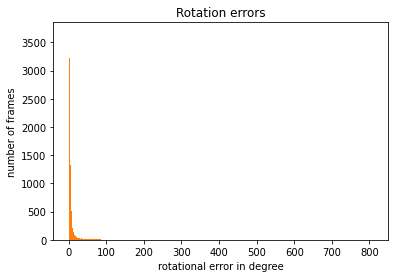

In [11]:
sio.savemat('results.mat', {'trans_pred': np.array(trans_preds), 'trans_gt': np.array(trans_gts), 'uncertainty': np.array(pred_uncertainties)})

if len(pose_map):
    np.savetxt(os.path.join(args.map_dataset, 'map.txt'), np.asarray(pose_map, dtype=np.float32))
    print("map is saved!")

plt.hist(trans_errors, bins='auto')
plt.title("Translation errors")
plt.xlabel("translational error in meters")
plt.ylabel("number of frames")
plt.savefig('terror.png', bbox_inches='tight')

plt.hist(rot_errors, bins='auto')
plt.title("Rotation errors")
plt.xlabel("rotational error in degree")
plt.ylabel("number of frames")
plt.savefig('rerror.png', bbox_inches='tight')

median_trans_errors = np.median(trans_errors)
median_rot_errors = np.median(rot_errors)
mean_trans_errors = np.mean(trans_errors)
mean_rot_errors = np.mean(rot_errors)

print("median translation error = {:.3f}".format(median_trans_errors))
print("median rotation error = {:.3f}".format(median_rot_errors))
print("mean translation error = {:.3f}".format(mean_trans_errors))
print("mean rotation error = {:.3f}".format(mean_rot_errors))   

median translation error = 2.107
median rotation error = 3.157
mean translation error = 11.000
mean rotation error = 6.656


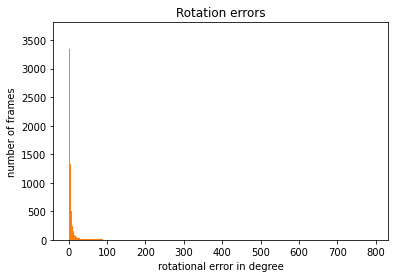

In [13]:
sio.savemat('results.mat', {'trans_pred': np.array(trans_preds), 'trans_gt': np.array(trans_gts), 'uncertainty': np.array(pred_uncertainties)})

if len(pose_map):
    np.savetxt(os.path.join(args.map_dataset, 'map.txt'), np.asarray(pose_map, dtype=np.float32))
    print("map is saved!")

plt.hist(trans_errors, bins='auto')
plt.title("Translation errors")
plt.xlabel("translational error in meters")
plt.ylabel("number of frames")
plt.savefig('terror.png', bbox_inches='tight')

plt.hist(rot_errors, bins='auto')
plt.title("Rotation errors")
plt.xlabel("rotational error in degree")
plt.ylabel("number of frames")
plt.savefig('rerror.png', bbox_inches='tight')

median_trans_errors = np.median(trans_errors)
median_rot_errors = np.median(rot_errors)
mean_trans_errors = np.mean(trans_errors)
mean_rot_errors = np.mean(rot_errors)

print("median translation error = {:.3f}".format(median_trans_errors))
print("median rotation error = {:.3f}".format(median_rot_errors))
print("mean translation error = {:.3f}".format(mean_trans_errors))
print("mean rotation error = {:.3f}".format(mean_rot_errors))   

In [14]:
def evaluate(trans_errors,rot_errors):
    t = [14301,7008,12852,9567,13580,14835,7114,12683]
    for i in range(len(t)):
        if i >0:
            t[i] += t[i-1]
    trans_errors_month = list()
    trans_errors_month.append(trans_errors[:t[0]])
    trans_errors_month.append(trans_errors[t[0]:t[1]])
    trans_errors_month.append(trans_errors[t[1]:t[2]])
    trans_errors_month.append(trans_errors[t[2]:t[3]])
    trans_errors_month.append(trans_errors[t[3]:t[4]])
    trans_errors_month.append(trans_errors[t[4]:t[5]])
    trans_errors_month.append(trans_errors[t[5]:t[6]])
    trans_errors_month.append(trans_errors[t[6]:])

    rot_errors_month = list()
    rot_errors_month.append(rot_errors[:t[0]])
    rot_errors_month.append(rot_errors[t[0]:t[1]])
    rot_errors_month.append(rot_errors[t[1]:t[2]])
    rot_errors_month.append(rot_errors[t[2]:t[3]])
    rot_errors_month.append(rot_errors[t[3]:t[4]])
    rot_errors_month.append(rot_errors[t[4]:t[5]])
    rot_errors_month.append(rot_errors[t[5]:t[6]])
    rot_errors_month.append(rot_errors[t[6]:])
    
    print('================== var translation error ==================')
    for trans_errors_i in trans_errors_month:
        print("var translation error = {:.3f}".format(np.var(trans_errors_i)))
    
    print('================== median translation error ==================')
    for trans_errors_i in trans_errors_month:
        print("median translation error = {:.3f}".format(np.median(trans_errors_i)))
        
    print('================== median rotation error ==================')
    for rot_errors_i in rot_errors_month:
        print("median rotation error = {:.3f}".format(np.median(rot_errors_i)))
    
    print('================== mean translation error ==================')
    for trans_errors_i in trans_errors_month:
        print("mean translation error = {:.3f}".format(np.mean(trans_errors_i)))
        
    print('================== mean rotation error ==================')  
    for rot_errors_i in rot_errors_month:
        print("mean rotation error = {:.3f}".format(np.mean(rot_errors_i)))
        
evaluate(trans_errors,rot_errors)

================== var translation error ==================
var translation error = 402.117
var translation error = 416.524
var translation error = 2593.646
var translation error = 3018.648
var translation error = 2113.461
var translation error = 3298.490
var translation error = 2728.619
var translation error = 3141.104
================== median translation error ==================
median translation error = 1.623
median translation error = 1.726
median translation error = 1.983
median translation error = 1.937
median translation error = 2.069
median translation error = 2.189
median translation error = 3.515
median translation error = 2.848
================== median rotation error ==================
median rotation error = 2.594
median rotation error = 2.827
median rotation error = 2.991
median rotation error = 2.949
median rotation error = 3.174
median rotation error = 3.317
median rotation error = 4.464
median rotation error = 4.193
================== mean translation error =========